In [1]:
import glob
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate as interp
import xarray as xr

from driftutils.find_nearest_grid_point import find_nearest_grid_point
from driftutils.ioutils import load_drifter_dataset

%matplotlib inline

In [2]:
testdata='/home/soontiensn/data/dynamic-test/'

u_files = glob.glob(os.path.join(testdata,'xwater*'))
u_files.sort()
print(u_files)

atm_files = glob.glob(os.path.join(testdata,'xwind*'))
atm_files.sort()
print(atm_files)

drifter_file = glob.glob(os.path.join(testdata,'1*.nc'))[0]
print(drifter_file)

meshfile = glob.glob(os.path.join(testdata,'mesh.nc'))[0]

lon_var='glamu'
lat_var='gphiu'
xwatervel='vozocrtx'
time_var='time_counter'

lon_var_atmos='nav_lon'
lat_var_atmos='nav_lat'
xwindvel='u_wind'

['/home/soontiensn/data/dynamic-test/xwatervel_00001.nc', '/home/soontiensn/data/dynamic-test/xwatervel_00002.nc', '/home/soontiensn/data/dynamic-test/xwatervel_00003.nc']
['/home/soontiensn/data/dynamic-test/xwindvel_ywindvel_00001.nc', '/home/soontiensn/data/dynamic-test/xwindvel_ywindvel_00002.nc', '/home/soontiensn/data/dynamic-test/xwindvel_ywindvel_00003.nc']
/home/soontiensn/data/dynamic-test/1UBC1461035736D2016041903.nc


In [3]:
dou = xr.open_mfdataset(u_files, concat_dim=time_var, combine='by_coords')
uocean = dou[xwatervel].isel(depthu=0)

da = xr.open_mfdataset(atm_files, concat_dim=time_var, combine='by_coords')
uatmos = da[xwindvel]

drifter = load_drifter_dataset(drifter_file)

mesh = xr.open_dataset(meshfile)

In [4]:
dres = drifter.resample(time='1H').interpolate('linear').dropna('time')

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/xarray/core/common.py:843: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  loffset))


# Plan
* Use scipy's LinearNDnterpolator and find_nearest_grid_point to truncate data
* test with just one point to start, then build up to multiple points.

In [5]:
def interpolate_variable_to_obs_track(dobs, dmodel, time_var, lon_var, lat_var, grid_dataset):
    lon_mod = np.squeeze(grid_dataset[lon_var].values)
    lon_mod_adjust = lon_mod.copy()
    lon_mod_adjust[lon_mod > 180] -= 360
    lat_mod = np.squeeze(grid_dataset[lat_var].values)
    time_mod = dmodel[time_var].values
    
    varis = []
    for t in range(len(dobs.time.values)):
        lat_obs = dobs.lat.values[t]
        lon_obs = dobs.lon.values[t]
        time_obs = dobs.time.values[t]
        # Indentify model space indices
        dist, j, i, lat_near, lon_near = find_nearest_grid_point(lat_obs, lon_obs, grid_dataset, lat_var, lon_var, n=10)
        Ny = dmodel.shape[-2]
        Nx = dmodel.shape[-1]
        if i[0] <=1 or i[0] >= Nx-2 or j[0] <=1 or j[0] >= Ny-2:
            #logger.debug("Drifter position ({},{}) outside of domain".format(lon_obs, lat_obs))
            print("Drifter position ({},{}) outside of domain".format(lon_obs, lat_obs))
            vari = np.empty((1,))
            vari[:] = np.nan
        else:
            # Identify model time indices
            tindex = np.argmin(np.abs(time_mod - time_obs))
            tindices = [tindex-1, tindex, tindex+1]
            if tindex == 0:
                 tindices.pop(0)
            elif tindex == len(time_mod) - 1:
                 tindices.pop(-1)
            
            # Build array of indices
            jss = np.tile(j, (len(tindices), 1)).flatten()
            iss = np.tile(i, (len(tindices), 1)).flatten()
            tss = np.tile(tindices, (len(j),1)).flatten(order='F')
            # Build variable arrays
            lonp = lon_mod_adjust[jss, iss]
            latp = lat_mod[jss, iss]
            tp = (time_mod[tss] - time_mod[0])/np.timedelta64(1, 's')
            varp = dmodel.values[tss, jss, iss]
            # Interpolation
            points = np.column_stack((tp, latp, lonp))
            ti = (time_obs- time_mod[0])/np.timedelta64(1, 's')
            f = interp.LinearNDInterpolator(points, varp)
            vari = f(np.column_stack((ti, lat_obs, lon_obs)))
        varis.append(vari[0])
    ds_var_is =  xr.Dataset(
        coords={'time': dobs.time.values},
        data_vars={'lon': ('time', dobs.lon.values),
                   'lat': ('time', dobs.lat.values),
                   'vari_ts': ('time', np.array(varis))}
    )
    return ds_var_is

In [6]:
%%time
uo_interp = interpolate_variable_to_obs_track(dres, uocean, time_var, lon_var, lat_var, mesh)

CPU times: user 6min 58s, sys: 1min 1s, total: 8min
Wall time: 6min 9s


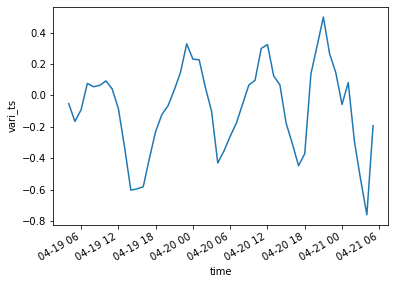

In [36]:
fig, ax = plt.subplots(1,1)
uo_interp['vari_ts'].plot(ax=ax)

In [6]:
atmos_dict = dict()
atmos_dict[time_var] = 0
datrun= da.isel(atmos_dict)
print(datrun.nav_lat.shape)

(850, 600)


In [48]:
%%time
ua_interp = interpolate_variable_to_obs_track(dres, uatmos, time_var, lon_var_atmos, lat_var_atmos, datrun)

CPU times: user 2min 7s, sys: 15.4 s, total: 2min 22s
Wall time: 32.9 s


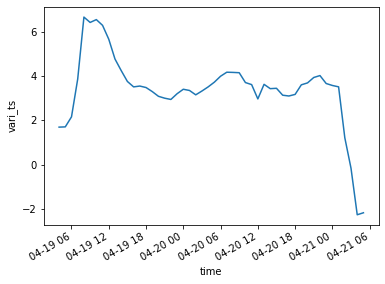

In [45]:
fig, ax = plt.subplots(1,1)
ua_interp['vari_ts'].plot(ax=ax)

In [46]:
ua_interp

<xarray.Dataset>
Dimensions:  (time: 50)
Coordinates:
  * time     (time) datetime64[ns] 2016-04-19T04:00:00 ... 2016-04-21T05:00:00
Data variables:
    lon      (time) float64 -123.3 -123.4 -123.4 -123.4 ... -123.0 -123.0 -123.0
    lat      (time) float64 49.18 49.17 49.16 49.15 ... 48.77 48.75 48.72 48.7
    vari_ts  (time) float64 1.696 1.708 2.161 3.874 ... -0.1656 -2.269 -2.179

In [30]:
print((datrun.nav_lat.values == np.nan).any())

False


A possible refactor if it turns out that looping through drifter positions once for each variable is a problem...

In [42]:
def interpolate_variable_to_obs_position(lon_obs, lat_obs, time_obs, dmodel, time_var, lon_var, lat_var, grid_dataset):
    lon_mod = np.squeeze(grid_dataset[lon_var].values)
    lon_mod_adjust = lon_mod.copy()
    lon_mod_adjust[lon_mod > 180] -= 360
    lat_mod = np.squeeze(grid_dataset[lat_var].values)
    time_mod = dmodel[time_var].values
    

    # Indentify model space indices
    dist, j, i, lat_near, lon_near = find_nearest_grid_point(lat_obs, lon_obs, grid_dataset, lat_var, lon_var, n=10)
    Ny = dmodel.shape[-2]
    Nx = dmodel.shape[-1]
    if i[0] <=1 or i[0] >= Nx-2 or j[0] <=1 or j[0] >= Ny-2:
        #logger.debug("Drifter position ({},{}) outside of domain".format(lon_obs, lat_obs))
        vari = np.empty((1,))
        vari[:] = np.nan
    else:
        # Identify model time indices
        tindex = np.argmin(np.abs(time_mod - time_obs))
        tindices = [tindex-1, tindex, tindex+1]
        if tindex == 0:
            tindices.pop(0)
        elif tindex == len(time_mod) - 1:
            tindices.pop(-1)
            
        # Build array of indices
        jss = np.tile(j, (len(tindices), 1)).flatten()
        iss = np.tile(i, (len(tindices), 1)).flatten()
        tss = np.tile(tindices, (len(j),1)).flatten(order='F')
        # Build variable arrays
        lonp = lon_mod_adjust[jss, iss]
        latp = lat_mod[jss, iss]
        tp = (time_mod[tss] - time_mod[0])/np.timedelta64(1, 's')
        varp = var.values[tss, jss, iss]
        # Interpolation
        points = np.column_stack((tp, latp, lonp))
        ti = (time_obs- time_mod[0])/np.timedelta64(1, 's')
        f = interp.LinearNDInterpolator(points, varp)
        vari = f(np.column_stack((ti, lat_obs, lon_obs)))

    return vari[0]

# using interp2d

In [18]:
def interpolate_time(var, t, ti):
    """Interpolate var(t) to time ti. Linear interpolation in time.
    var is an array of data with first index time (eg. [time, y, x])
    ti is a np.datetime64 object
    t is an array of np.datetime64 objects
    """

    # Define a reference time
    tr = t[0]
    # t and ti with repsect to epoc in seconds
    ti_tr = (ti-tr)/np.timedelta64(1, 's')
    t_tr = (t-tr)/np.timedelta64(1, 's')

    # Identify neighbouring time indices
    diff = ti_tr - t_tr
    i1 = np.argmin(np.abs(diff))
    sign = np.sign(diff[i1])
    i2 = int(i1 + sign*1)

    # Ensure i2 is in a valid range. In these cases, extrapolation will occur.
    # perhaps send a warning??
    if i1 == 0:
        i2 = i1 + 1
    elif i1 == len(t_tr) -1:
        i2 = i1 - 1

    # Edge case when i1 = i2 (sign is 0)
    if i1 == i2:
        vari = var[i1]
    else:
        # Interpolate
        vari = var[i1] +\
            (var[i2] - var[i1])/(t_tr[i2] - t_tr[i1])*(ti_tr-t_tr[i1])
    return vari


In [21]:
def interpolate_space(var, lon, lat, loni, lati):
    """ Interpolate field var(lon, lat) to (loni, lati)"""
    f = interp.interp2d(lon, lat, var, fill_value=np.nan)
    vari=f(loni, lati)
    return vari


In [21]:
def interpolate_variable_to_obs_track_orig(
    dobs, dmodel, time_var, lon_var, lat_var, grid_dataset):
    """Interpolate a model variable in space and time to an
    observed drifter position and time."""
    
    
    dmodel = dmodel.rename({time_var: 'time'})
    
    lon_mod = np.squeeze(grid_dataset[lon_var].values)
    lon_mod_adjust = lon_mod.copy()
    lon_mod_adjust[lon_mod > 180] -= 360
    lat_mod = np.squeeze(grid_dataset[lat_var].values)
    time_mod = dmodel['time'].values
    
    varis = []
    for t in range(len(dobs.time.values)):
        lat_obs = dobs.lat.values[t]
        lon_obs = dobs.lon.values[t]
        time_obs = dobs.time.values[t]
        # Identify closest grid cell and interpolate in space
        dist, j, i, lat_near, lon_near =\
            find_nearest_grid_point(lat_obs, lon_obs,
                                    grid_dataset,
                                    lat_var, lon_var,
                                    n=10)
        Ny = dmodel.shape[-2]
        Nx = dmodel.shape[-1]
        if i[0] <=1 or i[0] >= Nx-2 or j[0] <=1 or j[0] >= Ny-2:
            logger.debug("Drifter position ({},{}) outside of domain".format(loni, lati))
            vari_ts = np.empty((1,))
            vari_ts[:] = np.nan
        else:
            # Truncate data so that only neighbours are used in interpolation.
            truncated = dmodel[:, j, i]
            # Interpolate in time
            vari_t = interpolate_time(truncated, dmodel['time'].values, time_obs)
            #vari_t = truncated.interp(time=time_obs)
            # Interpolate in space
            vari_ts = interpolate_space(vari_t,
                                        lon_mod_adjust[j, i],
                                        lat_mod[j, i],
                                        lon_obs,
                                        lat_obs)
   
        varis.append(vari_ts[0])
    ds_vari_ts = xr.Dataset(
        coords={'time': dobs.time.values},
        data_vars={'lon': ('time', dobs.lon.values),
                   'lat': ('time', dobs.lat.values),
                   'vari_ts': ('time', np.array(varis))}
        )
    return ds_vari_ts


In [22]:
%%time
uo_interp = interpolate_variable_to_obs_track_orig(dres, uocean, time_var, lon_var, lat_var, mesh)

CPU times: user 4min 5s, sys: 36.5 s, total: 4min 41s
Wall time: 2min 56s


# scipy griddata


In [26]:
def interpolate_variable_to_obs_track_griddata(dobs, dmodel, time_var, lon_var, lat_var, grid_dataset):

    
    dmodel = dmodel.rename({time_var: 'time'})
    
    lon_mod = np.squeeze(grid_dataset[lon_var].values)
    lon_mod_adjust = lon_mod.copy()
    lon_mod_adjust[lon_mod > 180] -= 360
    lat_mod = np.squeeze(grid_dataset[lat_var].values)
    time_mod = dmodel['time'].values
    
    varis = []
    for t in range(len(dobs.time.values)):
        lat_obs = dobs.lat.values[t]
        lon_obs = dobs.lon.values[t]
        time_obs = dobs.time.values[t]
        # Identify closest grid cell and interpolate in space
        dist, j, i, lat_near, lon_near =\
            find_nearest_grid_point(lat_obs, lon_obs,
                                    grid_dataset,
                                    lat_var, lon_var,
                                    n=10)
        Ny = dmodel.shape[-2]
        Nx = dmodel.shape[-1]
        if i[0] <=1 or i[0] >= Nx-2 or j[0] <=1 or j[0] >= Ny-2:
            logger.debug("Drifter position ({},{}) outside of domain".format(loni, lati))
            vari_ts = np.empty((1,))
            vari_ts[:] = np.nan
        else:
            # Truncate data so that only neighbours are used in interpolation.
            truncated = dmodel[:, j, i]
            # Interpolate in time
            vari_t = interpolate_time(truncated, dmodel['time'].values, time_obs)
            # Interpolate in space
            vari_ts = interp.griddata((lon_mod_adjust[j,i], lat_mod[j,i]),
                                     vari_t, (lon_obs, lat_obs))
   
        varis.append(vari_ts[0])
    ds_vari_ts = xr.Dataset(
        coords={'time': dobs.time.values},
        data_vars={'lon': ('time', dobs.lon.values),
                   'lat': ('time', dobs.lat.values),
                   'vari_ts': ('time', np.array(varis))}
        )
    return ds_vari_ts

In [27]:
%%time
uo_interp = interpolate_variable_to_obs_track_griddata(dres, uocean, time_var, lon_var, lat_var, mesh)

CPU times: user 4min 7s, sys: 36.6 s, total: 4min 44s
Wall time: 2min 54s


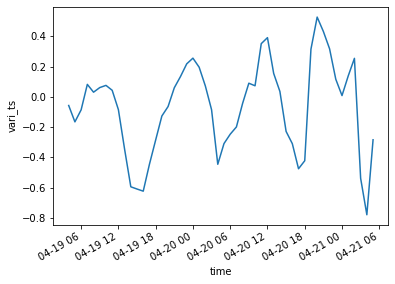

In [28]:
fig, ax = plt.subplots(1,1)
uo_interp['vari_ts'].plot(ax=ax)

# No truncate - errors - too many data points

In [40]:
def interpolate_variable_to_obs_track_notruncate(
    dobs, dmodel, time_var, lon_var, lat_var, grid_dataset):
    """Interpolate a model variable in space and time to an
    observed drifter position and time."""
    
    
    dmodel = dmodel.rename({time_var: 'time'})
    
    lon_mod = np.squeeze(grid_dataset[lon_var].values)
    lon_mod_adjust = lon_mod.copy()
    lon_mod_adjust[lon_mod > 180] -= 360
    lat_mod = np.squeeze(grid_dataset[lat_var].values)
    time_mod = dmodel['time'].values
    
    varis = []
    for t in range(len(dobs.time.values)):
        lat_obs = dobs.lat.values[t]
        lon_obs = dobs.lon.values[t]
        time_obs = dobs.time.values[t]
        ## Identify closest grid cell and interpolate in space
        #dist, j, i, lat_near, lon_near =\
        #    find_nearest_grid_point(lat_obs, lon_obs,
        #                            grid_dataset,
        #                            lat_var, lon_var,
        #                            n=10)
        #Ny = dmodel.shape[-2]
        #Nx = dmodel.shape[-1]
        #if i[0] <=1 or i[0] >= Nx-2 or j[0] <=1 or j[0] >= Ny-2:
        #    logger.debug("Drifter position ({},{}) outside of domain".format(loni, lati))
        #    vari_ts = np.empty((1,))
        #    vari_ts[:] = np.nan
        #else:
            # Truncate data so that only neighbours are used in interpolation.
            # Interpolate in time
        vari_t = interpolate_time(dmodel, dmodel['time'].values, time_obs)
        #vari_t = truncated.interp(time=time_obs)
        # Interpolate in space
        vari_ts = interp.griddata((lon_mod_adjust.flatten(), lat_mod.flatten()), vari_t.values.flatten(),
                                  (lon_obs,lat_obs))
        varis.append(vari_ts)
    ds_vari_ts = xr.Dataset(
        coords={'time': dobs.time.values},
        data_vars={'lon': ('time', dobs.lon.values),
                   'lat': ('time', dobs.lat.values),
                   'vari_ts': ('time', np.array(varis))}
        )
    return ds_vari_ts

In [41]:
%%time
uo_interp = interpolate_variable_to_obs_track_notruncate(dres, uocean, time_var, lon_var, lat_var, mesh)

CPU times: user 2min 59s, sys: 4.05 s, total: 3min 3s
Wall time: 3min 3s
